<a href="https://colab.research.google.com/github/Psyclophe/datasets/blob/master/Semana2_1_Aps_Financieras5_Intro_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana2/Intro_Keras..ipynb)

# Problema

Esta semana utilizaremos el mismo DataSet para ambas sesiones. Ésta primera sesión será para analizar un problema de fraude de modo sencillo, es decir, con un clasificador binario sencillo (que nos servirá para introducir algunas herramientas).

Podemos encontrar la base de datos en https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Los datos contienen transacciones realizadas mediante trarjeta de crédito en Septiembre del 2013 por titulares de tarjeta en Europa. Ocurrieron en 2 días en los que hubo 492 fraudes de 284,807 transacciones.

Solo contiene variables numéricas y ya pasó por un proceso de PCA para solo quedarse con las mejores características.

La columna de "Time" contiene los segundos ocurridos entre transacciones. "Amount" es la cantidad de la transacción y "Class" es la variable que tiene 1 en caso de fraude y 0 en caso contrario.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Leer Datos usando un método distinto al que estamos acostumbrados

In [2]:
import numpy as np

# Datos disponibles en https://www.kaggle.com/mlg-ulb/creditcardfraud/

all_features = []
all_targets = []
with open('/content/drive/MyDrive/Cruso-ApsFinancieras/semana3/creditcard.csv') as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("EJEMPLO DE CARACTERÍSTICAS:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EJEMPLO DE CARACTERÍSTICAS: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


In [3]:
import pandas as pd

en_dataframe = pd.read_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/semana3/creditcard.csv')

In [4]:
en_dataframe

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
features2 = np.array(en_dataframe.iloc[:, :-1])
targets2 = np.array(en_dataframe.iloc[:,-1])

In [6]:
np.allclose(features, features2, rtol=0.0000001)

True

## Cuidado con las dimensiones, pueden crear problemas extraños

Rompemos la RAM, solo para mostrar cosas que pueden fallar, despues no ejecutaremos esta linea

In [ ]:
# Si está descomentada, supera nuestra RAM disponible
# np.allclose(targets, targets2)

In [7]:
# Esta variable casi llena nuestra RAM, la borraremos abajo
aux = (targets[:100000] == targets2[:100000])

In [10]:
targets

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

In [11]:
targets2

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
aux.shape

(100000, 100000)

In [9]:
del aux

# Corrección

La manera correcta para poder llevar a cabo esta comparación es cuidando las dimensiones de los objetos que estamos comparando

In [ ]:
targets.shape

(284807, 1)

In [ ]:
targets2.shape

(284807,)

In [12]:
features2 = np.array(en_dataframe.iloc[:, :-1])
targets2 = np.array(en_dataframe.iloc[:,-1]).reshape(-1, 1)  # Cambio aqui para redimensionar


In [13]:
np.allclose(targets, targets2, rtol=1e-05)

True

# Preparar conjunto de validación

Lo haremos manual (es decir, no aleatorio)

In [14]:
num_val_samples = int(len(features) * 0.2)

# 80% datos para entrenamiento
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]

# 20% de datos para test
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Número de muestras para entrenamiento:", len(train_features))
print("Número de muestras para validación:", len(val_features))

#revisar las dimensiones para evitar la memoria rompa

#los 27k son para entrenamineto
#los 59 son para test

Número de muestras para entrenamiento: 227846
Número de muestras para validación: 56961


In [15]:
num_val_samples

56961

# Analizar desbalance de los datos

In [16]:
counts = np.bincount(train_targets[:, 0])
print(f"Número de valores 1 en muestra de entrenamiento: {counts[1]} ({100 * float(counts[1]) / len(train_targets):.2f}% of total)")

#los 417 son 1

Número de valores 1 en muestra de entrenamiento: 417 (0.18% of total)


Asignaremos pesos de una manera balanceada (es una clase de peso "balanced" utilizada en keras). Manualmente se calcula como:

In [17]:
total_counts = np.bincount(train_targets[:, 0])
n_samples = len(train_targets)

weight_for_0 = n_samples / (total_counts[0]*2)
weight_for_1 = n_samples / (total_counts[1]*2)

#counts = np.bincount(train_targets[:, 0])

#weight_for_0 = 1.0 / counts[0]
#weight_for_1 = 1.0 / counts[1]

print(f"{weight_for_0: .6f}")
print(f"{weight_for_1: .4f}")

 0.500917
 273.1966


Podemos ver que los pesos son practicamente una proporción de 500 a 1 aproximadamente

# Estandarizar los datos

In [19]:
mean = np.mean(train_features, axis=0) #ojo con Axis=0 checar grabacion
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std #son promedios

# Modelo de clasificación binaria

## Slicing para arrays

In [20]:
arreglo = np.array([[1,2,3], [4,5,6]])
arreglo

array([[1, 2, 3],
       [4, 5, 6]])

In [22]:
arreglo[:, 1:] #son filas y columnas

array([[2, 3],
       [5, 6]])

In [23]:
# Removemos la columnas correspondiente a tiempo
train_features = train_features[:, 1:]
val_features = val_features[:, 1:]

In [ ]:
train_features.shape[-1]

29

In [24]:
#supervisado
from tensorflow import keras
import tensorflow as tf

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7680      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 139,521
Trainable params: 139,521
Non-trai

# Entrenar modelo tomando en cuenta pesos para los datos


In [25]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss="binary_crossentropy", metrics=metrics # El 0.01 es llamado "learning rate"
)

# Para poder guardar info del entranamiento
callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]

# Utilizada para asignar pesos que "balanceen" las clases
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    train_features,
    train_targets,
    batch_size=2048, # Cantidad de datos que optimizan pesos por cada pasada, "batch size"
    epochs=30, # Cantidad de pasadas que dan todos los datos, para entrenamiento
    verbose=2,
    callbacks=callbacks, #guardando los parametros
    validation_data=(val_features, val_targets), # Solo para medir como va avanzando el modelo, no utiliza estos datos para modificar pesos
    class_weight=class_weight,
)

Epoch 1/30
112/112 - 11s - loss: 0.5220 - fn: 50.0000 - fp: 15055.0000 - tn: 212374.0000 - tp: 367.0000 - precision: 0.0238 - recall: 0.8801 - val_loss: 0.3780 - val_fn: 8.0000 - val_fp: 1996.0000 - val_tn: 54890.0000 - val_tp: 67.0000 - val_precision: 0.0325 - val_recall: 0.8933 - 11s/epoch - 94ms/step
Epoch 2/30
112/112 - 7s - loss: 0.3704 - fn: 41.0000 - fp: 10581.0000 - tn: 216848.0000 - tp: 376.0000 - precision: 0.0343 - recall: 0.9017 - val_loss: 0.3580 - val_fn: 10.0000 - val_fp: 2054.0000 - val_tn: 54832.0000 - val_tp: 65.0000 - val_precision: 0.0307 - val_recall: 0.8667 - 7s/epoch - 67ms/step
Epoch 3/30
112/112 - 8s - loss: 0.4151 - fn: 30.0000 - fp: 12155.0000 - tn: 215274.0000 - tp: 387.0000 - precision: 0.0309 - recall: 0.9281 - val_loss: 0.4530 - val_fn: 4.0000 - val_fp: 8108.0000 - val_tn: 48778.0000 - val_tp: 71.0000 - val_precision: 0.0087 - val_recall: 0.9467 - 8s/epoch - 68ms/step
Epoch 4/30
112/112 - 9s - loss: 1.0225 - fn: 39.0000 - fp: 18009.0000 - tn: 209420.0000 

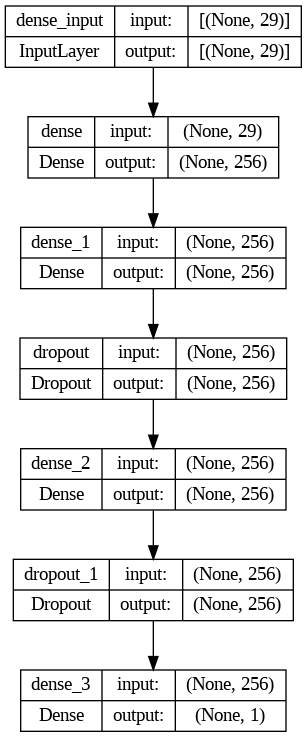

In [26]:
tf.keras.utils.plot_model( 
    model,
    #to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    #dpi=96,
)

In [27]:
y_train_pred = model.predict(train_features)
y_train_pred[y_train_pred < 0.5] = 0
y_train_pred[y_train_pred >= 0.5] = 1

7121/7121 [==============================] - 15s 2ms/step


In [28]:
y_test_pred = model.predict(val_features)
y_test_pred[y_test_pred < 0.5] = 0
y_test_pred[y_test_pred >= 0.5] = 1

1781/1781 [==============================] - 4s 2ms/step


In [29]:
len(y_test_pred[:, 0])

56961

In [30]:
y_test_pred[:, 0].sum()

7632.0

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

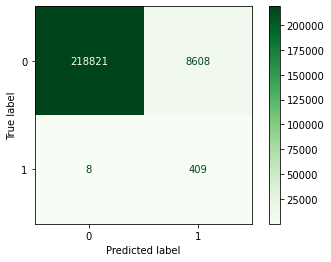

In [ ]:
ConfusionMatrixDisplay.from_predictions(train_targets, y_train_pred, cmap=plt.cm.Greens)

In [ ]:
# Recuperar "pesos" de los coeficientes en la epoca "X"
# CUIDADO AL CORRER ESTA CELDA

# model.load_weights("/content/fraud_model_at_epoch_25.h5")

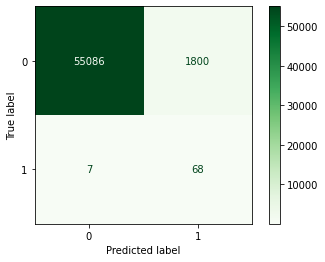

In [ ]:
ConfusionMatrixDisplay.from_predictions(val_targets, y_test_pred, cmap=plt.cm.Greens)

In [32]:
from sklearn.metrics import average_precision_score

In [33]:
y_test_prob = model.predict(val_features)

1781/1781 [==============================] - 4s 2ms/step


In [34]:
y_test_prob

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.54253966]], dtype=float32)

In [35]:
auprc = average_precision_score(val_targets, y_test_prob)
auprc

0.6687482145638969

In [36]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(train_targets, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    227429
           1       0.05      0.98      0.09       417

    accuracy                           0.96    227846
   macro avg       0.52      0.97      0.53    227846
weighted avg       1.00      0.96      0.98    227846



In [ ]:
print(classification_report(val_targets, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56886
           1       0.04      0.91      0.07        75

    accuracy                           0.97     56961
   macro avg       0.52      0.94      0.53     56961
weighted avg       1.00      0.97      0.98     56961



# Ejercicios:

* ¿Que sucedería con el modelo si no usamos el parámetro "class_weight"?

* ¿Podemos recuperar solo la mejor época de nuestro entrenamiento?

* ¿Porque la matriz de confusión no parece dar mucha luz sobre lo que ocurre?

 - Cargar los datos utilizando Pandas
 - Realizar la división de entrenamiento y prueba usando la función 'train_test_split' de sklearn

In [ ]:
# Código de ejercicio, puede crear mas celdas

